In [1]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule

from matplotlib import pyplot as plt
%matplotlib inline


# Define constants.
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trials = 10
n_eval_trials = 5


# Initialize dictionary.
reports = {}

model_names = [
    "icassp-convnet",
#    "icassp-ntt-convnet",
#    "icassp-add-convnet",
    "pcen-convnet",
#    "pcen-ntt-convnet",
    "pcen-add-convnet"
]


# Loop over models.
for model_name in model_names:
    
    # Initialize dictionary.
    report = {}

    # Loop over augmentations.
    for aug_kind_str in ["none", "all-but-noise", "all"]:

        
        # Initialize dictionaries.
        aug_report = {
            "validation": {},
            "test-CV-F": {},
        }


        # Initialize precisions, recalls, and F1 scores.
        val_precisions = np.zeros((n_units, n_trials))
        val_recalls = np.zeros((n_units, n_trials))
        val_f1_scores = np.zeros((n_units, n_trials))
        val_thresholds = np.zeros((n_units, n_trials))
        val_threshold_ids = np.zeros((n_units, n_trials))
        val_auprcs = np.zeros((n_units, n_trials))

        
        # Define thresholds.
        thresholds = 1.0 - np.concatenate((
            np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
        ))
        n_thresholds = len(thresholds)


        # Define model directory.
        if not aug_kind_str == "none":
            aug_model_name = "_".join([model_name, "aug-" + aug_kind_str])
        else:
            aug_model_name = model_name
        model_dir = os.path.join(models_dir, aug_model_name)


        # Loop over test units.
        for test_unit_id in range(n_units):

            # Define directory for test unit.
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)

            # Retrieve fold such that unit_str is in the test set.
            folds = localmodule.fold_units()
            fold = [f for f in folds if test_unit_str in f[0]][0]
            test_units = fold[0]
            validation_units = fold[2]

            # Loop over trials.
            for trial_id in range(n_trials):

                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)
                break_switch = False

                # Loop over validation units.
                for predict_unit_str in validation_units:
                    val_metrics_name = "_".join([
                        dataset_name,
                        aug_model_name,
                        "test-" + test_unit_str,
                        trial_str,
                        "predict-" + predict_unit_str,
                        "full-audio-metrics.csv"
                    ])
                    val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                    val_tp = np.zeros((n_thresholds,))
                    val_fp = np.zeros((n_thresholds,))
                    val_fn = np.zeros((n_thresholds,))
                    try:
                        val_metrics_df = pd.read_csv(val_metrics_path)
                        val_tp = val_tp + np.array(val_metrics_df["True positives"])
                        val_fp = val_fp + np.array(val_metrics_df["False positives"])
                        val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                    except:
                        break_switch = True
                        break

                if break_switch:
                    val_auprc = 0.0
                    val_p = np.zeros((n_thresholds,))
                    val_r = np.zeros((n_thresholds,))
                    val_f = np.zeros((n_thresholds,))
                    val_threshold_id = 0
                else:
                    val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                    val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                    val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                    val_threshold_id = np.argmax(val_f)
                    val_p_ = np.array([1.0] + list(val_p) + [0.0])
                    val_r_ = np.array([0.0] + list(val_r) + [1.0])
                    val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

                val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
                val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
                val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
                val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
                val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
                val_auprcs[test_unit_id, trial_id] = val_auprc


        aug_report["validation"]["P"] = val_precisions
        aug_report["validation"]["R"] = val_recalls
        aug_report["validation"]["F"] = val_f1_scores
        aug_report["validation"]["AUPRC"] = val_auprcs
        aug_report["validation"]["threshold"] = val_thresholds
        aug_report["validation"]["threshold_ids"] = val_threshold_ids
        aug_report["validation"]["trials_F"] = np.argsort(val_f1_scores, axis=1)
        aug_report["validation"]["trials_AUPRC"] = np.argsort(val_auprcs, axis=1)


        # Initialize precisions, recalls, and F1 scores.
        F_trials = aug_report["validation"]["trials_F"]
        test_precisions = np.zeros((n_units, n_trials))
        test_recalls = np.zeros((n_units, n_trials))
        test_f1_scores = np.zeros((n_units, n_trials))
        test_bools = np.ones((n_units, n_trials), dtype=bool)

        
        # Loop over test units.
        for test_unit_id in range(n_units):
            test_unit_str = units[test_unit_id]
            test_unit_dir = os.path.join(model_dir, test_unit_str)
        
            # Loop over trials.
            for eval_trial_id in range(n_trials):
                trial_id = F_trials[test_unit_id, eval_trial_id]
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    aug_model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                
                threshold_id = int(val_threshold_ids[test_unit_id, trial_id])
        
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = np.array(test_metrics_df["True positives"])
                    test_tp = test_tp[threshold_id]
                    test_fp = np.array(test_metrics_df["False positives"])
                    test_fp = test_fp[threshold_id]
                    test_fn = np.array(test_metrics_df["False negatives"])
                    test_fn = test_fn[threshold_id]
                    
                    test_p = test_tp / (test_tp+test_fp)
                    test_r = test_tp /(test_tp+test_fn)
                    test_f1_score = (2*test_p*test_r) / (test_p+test_r)
                    
                    test_precisions[test_unit_id, trial_id] = test_p
                    test_recalls[test_unit_id, trial_id] = test_r
                    test_f1_scores[test_unit_id, trial_id] = test_f1_score
                    
                except:
                    test_bools[test_unit_id, trial_id] = False
          
        
        aug_report["test-CV-F"]["P"] = test_precisions
        aug_report["test-CV-F"]["R"] = test_recalls
        aug_report["test-CV-F"]["F"] = test_f1_scores 
        aug_report["test-CV-F"]["is_valid"] = test_bools
        
        report[aug_kind_str] = aug_report
    
    reports[model_name] = report

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

array([[0.76995842, 0.03106419, 0.15416136, 0.77030923, 0.30022622,
        0.28617695, 0.25010862, 0.30021405, 0.25004214, 0.75642367],
       [0.16717924, 0.68513694, 0.11177717, 0.        , 0.16505747,
        0.74708528, 0.04795965, 0.0628406 , 0.16730813, 0.07520618],
       [0.50000659, 0.05827395, 0.04151397, 0.6768122 , 0.50000703,
        0.62901757, 0.64642096, 0.60493724, 0.11130519, 0.10567796],
       [0.74944536, 0.        , 0.09101228, 0.14295564, 0.68689743,
        0.15017977, 0.09103414, 0.12511178, 0.08343712, 0.13649737],
       [0.61576287, 0.05009278, 0.62522103, 0.50278046, 0.10008461,
        0.25005427, 0.04176005, 0.5       , 0.03342756, 0.02513928],
       [0.05890863, 0.72563491, 0.17875118, 0.81288982, 0.06127136,
        0.16672249, 0.81461879, 0.16676054, 0.82802297, 0.16674585]])

7 0.9943765867480965 0.240758094698862
7 0.8741074588205833 0.5516407850674435
2 0.9992056717652757 0.5660798146487648
0 0.99 0.7652391788803026
3 0.9910874906186625 0.4398901583504513
0 0.999999999 0.0
6 0.999999999 0.0


KeyboardInterrupt: 

<Figure size 360x216 with 0 Axes>

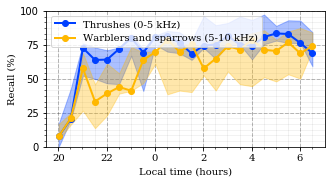

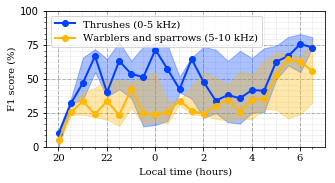

In [25]:
import datetime
import matplotlib.pylab
import mir_eval
import numpy as np
import peakutils


thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
))
n_thresholds = len(thresholds)
tolerance = 0.5 # in seconds
n_hours = 11
bin_hop = 30 # in minutes
n_bins = int(np.round(n_hours * (60/bin_hop)))
bins = (3600 * np.linspace(0, n_hours, 1 + n_bins)).astype('int')
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
test_unit_id = 0


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


model_pairs = [
    ["icassp-convnet", "all"],
    ["pcen-convnet", "all-but-noise"],
    ["pcen-add-convnet", "all-but-noise"]
]

plt.figure(figsize=(5, 3))


for model_pair_id, model_pair in enumerate(model_pairs):
    
    model_name = model_pair[0]
    aug_kind_str = model_pair[1]
    
    if aug_kind_str == "none":
        aug_model_name = model_name
    else:
        aug_model_name = "_".join([
            model_name, "aug-" + aug_kind_str])


    model_dir = os.path.join(models_dir, aug_model_name)


    model_report = reports[model_name][aug_kind_str]

    thrush_Fs = []
    tseep_Fs = []

    thrush_Rs = []
    tseep_Rs = []

    # We do not include unit10 in the visualization because
    # it is shorter (6 hours) than the other recordings (10 hours).
    for test_unit_id in range(n_units)[:-1]:    
        # Define directory for trial.
        trial_id = model_report[
            "validation"]["trials_AUPRC"][test_unit_id, -1]
        trial_str = "trial-" + str(trial_id)
        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)
        trial_dir = os.path.join(test_unit_dir, trial_str)


        # Load predictions.
        predictions_name = "_".join([
            dataset_name,
            aug_model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "full-predictions.csv"
        ])
        prediction_path = os.path.join(trial_dir, predictions_name)
        prediction_df = pd.read_csv(prediction_path)
        odf = np.array(prediction_df["Predicted probability"])
        timestamps = np.array(prediction_df["Timestamp"])


        # Load threhold.
        threshold_id = int(model_report[
            "validation"]["threshold_ids"][test_unit_id, -1])
        threshold = thresholds[threshold_id]


        # Select peaks.
        threshold = thresholds[threshold_id]
        if model_name == "pcen-add-convnet":
            peak_locations = peakutils.indexes(odf, thres=threshold)
        else:
            peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
        selected = timestamps[peak_locations]


        # Load annotation.
        annotation_path = os.path.join(annotations_dir,
            test_unit_str + ".txt")
        annotation = pd.read_csv(annotation_path, '\t')
        begin_times = np.array(annotation["Begin Time (s)"])
        end_times = np.array(annotation["End Time (s)"])
        relevant = 0.5 * (begin_times + end_times)
        relevant = np.sort(relevant)
        high_freqs = np.array(annotation["High Freq (Hz)"])
        low_freqs = np.array(annotation["Low Freq (Hz)"])
        mid_freqs = 0.5 * (high_freqs + low_freqs)
        n_relevant = len(relevant)


        # Filter by frequency ranges.
        thrush_low = 1000.0
        thrush_high = 5000.0
        thrush_relevant = relevant[(thrush_low < mid_freqs) & (mid_freqs < thrush_high)]
        tseep_low = 5000.0
        tseep_high = 10000.0
        tseep_relevant = relevant[(tseep_low < mid_freqs) & (mid_freqs < tseep_high)]

        # Match events for all calls.
        selected_relevant = mir_eval.util.match_events(relevant, selected, tolerance)
        tp_relevant_ids = list(zip(*selected_relevant))[0]
        tp_relevant_times = [relevant[i] for i in tp_relevant_ids]
        tp_selected_ids = list(zip(*selected_relevant))[1]
        tp_selected_times = [selected[i] for i in tp_selected_ids]

        # Compute number of false positives through time.
        fp_times = [selected[i] for i in range(len(selected)) if i not in tp_selected_ids]
        fp_x, fp_y = np.histogram(fp_times, bins=bins);

        # Match events for Thrush calls. Get number of true positives through time.
        thrush_selected_relevant = mir_eval.util.match_events(
            thrush_relevant, selected, tolerance)
        thrush_tp_relevant_ids = list(zip(*thrush_selected_relevant))[0]
        thrush_tp_relevant_times = [thrush_relevant[i] for i in thrush_tp_relevant_ids]
        thrush_tp_selected_ids = list(zip(*thrush_selected_relevant))[1]
        thrush_tp_selected_times = [selected[i] for i in thrush_tp_selected_ids]
        thrush_tp_x, thrush_tp_y = np.histogram(thrush_tp_relevant_times, bins=bins);

        # Get number of false negatives for Thrush.
        thrush_fn_times = [thrush_relevant[i] for i in range(len(thrush_relevant))
            if i not in thrush_tp_relevant_ids]
        thrush_fn_x, thrush_fn_y = np.histogram(thrush_fn_times, bins=n_bins);

        # Get Thrush precision through time.
        thrush_P = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + fp_x)
        thrush_R = thrush_tp_x / (np.finfo(float).eps + thrush_tp_x + thrush_fn_x)
        thrush_F = (2*thrush_P*thrush_R) / (np.finfo(float).eps + thrush_P + thrush_R)


        # Match events for Thrush calls. Get number of true positives through time.
        tseep_selected_relevant = mir_eval.util.match_events(
            tseep_relevant, selected, tolerance)
        tseep_tp_relevant_ids = list(zip(*tseep_selected_relevant))[0]
        tseep_tp_relevant_times = [tseep_relevant[i] for i in tseep_tp_relevant_ids]
        tseep_tp_selected_ids = list(zip(*tseep_selected_relevant))[1]
        tseep_tp_selected_times = [selected[i] for i in tseep_tp_selected_ids]
        tseep_tp_x, tseep_tp_y = np.histogram(tseep_tp_relevant_times, bins=bins);

        # Get number of false negatives for Tseep.
        tseep_fn_times = [tseep_relevant[i] for i in range(len(tseep_relevant))
            if i not in tseep_tp_relevant_ids]
        tseep_fn_x, tseep_fn_y = np.histogram(tseep_fn_times, bins=n_bins);

        # Get Tseep precision through time.
        tseep_P = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + fp_x)
        tseep_R = tseep_tp_x / (np.finfo(float).eps + tseep_tp_x + tseep_fn_x)
        tseep_F = (2*tseep_P*tseep_R) / (np.finfo(float).eps + tseep_P + tseep_R)

        thrush_Fs.append(thrush_F)
        tseep_Fs.append(tseep_F)

        thrush_Rs.append(thrush_R)
        tseep_Rs.append(tseep_R)
        
        print(trial_id, threshold, model_report["validation"]["AUPRC"][test_unit_id, -1])
        
        
    utc_timestamp = 1443065462
    utc_datetime = datetime.datetime.fromtimestamp(utc_timestamp)
    utc_offset =\
        utc_datetime.hour +\
        utc_datetime.minute / 60 +\
        utc_datetime.second / 3600
    local_offset = utc_offset - 4
    first_hour = 20

    thrush_R_Q1 = np.percentile(np.stack(thrush_Rs), 25, axis=0)
    thrush_R_med = np.percentile(np.stack(thrush_Rs), 50, axis=0)
    thrush_R_Q3 = np.percentile(np.stack(thrush_Rs), 75, axis=0)

    thrush_F_Q1 = np.percentile(np.stack(thrush_Fs), 25, axis=0)
    thrush_F_med = np.percentile(np.stack(thrush_Fs), 50, axis=0)
    thrush_F_Q3 = np.percentile(np.stack(thrush_Fs), 75, axis=0)
    
    
    tseep_R_Q1 = np.percentile(np.stack(tseep_Rs), 25, axis=0)
    tseep_R_med = np.percentile(np.stack(tseep_Rs), 50, axis=0)
    tseep_R_Q3 = np.percentile(np.stack(tseep_Rs), 75, axis=0)

    tseep_F_Q1 = np.percentile(np.stack(tseep_Fs), 25, axis=0)
    tseep_F_med = np.percentile(np.stack(tseep_Fs), 50, axis=0)
    tseep_F_Q3 = np.percentile(np.stack(tseep_Fs), 75, axis=0)
    
    plt.figure(figsize=(5, 2.5))
    fig = plt.gcf()
    ax1 = plt.gca()

    ax1.fill_between(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_R_Q1[:],
        100 * thrush_R_Q3[:],
        color = "#0040FF",
        alpha = 0.33)

    ax1.plot(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_R_med[:],
        "-o",
        color = "#0040FF",
        linewidth = 2.0)

    ax1.fill_between(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_R_Q1[:],
        100 * tseep_R_Q3[:],
        color = "#FFB800",
        alpha = 0.33)

    ax1.plot(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_R_med[:],
        "-o",
        color = "#FFB800",
        linewidth = 2.0)

    ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
        loc=2, prop={'family':'serif'})

    ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
    ax1.set_xticklabels([str(np.mod(n, 24))
        for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
    ax1.set_xticks(
        np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
        minor=True)
    ax1.set_xlabel("Local time (hours)", family="serif")

    ax1.set_ylim(0, 100)
    ax1.set_ylabel("Recall (%)", family="serif")
    ax1.set_yticks(np.linspace(0, 100, 5))
    ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

    ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
    ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
    ax1.set_axisbelow(True)
    
    if aug_model_name == "icassp-convnet":
        plt.title("CNN baseline (previous state of the art) [57]", family="serif")
    elif aug_model_name == "pcen-convnet":
        plt.title("CNN with PCEN", family="serif")
    elif aug_model_name == "pcen-add-convnet":
        plt.title("CNN with PCEN and context adaptation", family="serif")
    
    plt.savefig("spl_recall-time_" + aug_model_name + ".png", dpi=500, bbox_inches="tight")
    plt.savefig("spl_recall-time_" + aug_model_name + ".svg", bbox_inches="tight")
    
    
    plt.figure(figsize=(5, 2.5))
    fig = plt.gcf()
    ax1 = plt.gca()

    ax1.fill_between(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_F_Q1[:],
        100 * thrush_F_Q3[:],
        color = "#0040FF",
        alpha = 0.33)

    ax1.plot(
        thrush_tp_y[1:] / 3600 + local_offset,
        100 * thrush_F_med[:],
        "-o",
        color = "#0040FF",
        linewidth = 2.0)

    ax1.fill_between(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_F_Q1[:],
        100 * tseep_F_Q3[:],
        color = "#FFB800",
        alpha = 0.33)

    ax1.plot(
        tseep_tp_y[1:] / 3600 + local_offset,
        100 * tseep_F_med[:],
        "-o",
        color = "#FFB800",
        linewidth = 2.0)

    ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
        loc=2, prop={'family':'serif'})

    ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
    ax1.set_xticklabels([str(np.mod(n, 24))
        for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
    ax1.set_xticks(
        np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
        minor=True)
    ax1.set_xlabel("Local time (hours)", family="serif")

    ax1.set_ylim(0, 100)
    ax1.set_ylabel("F1 score (%)", family="serif")
    ax1.set_yticks(np.linspace(0, 100, 5))
    ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

    ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
    ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
    ax1.set_axisbelow(True)
    
    if aug_model_name == "icassp-convnet":
        plt.title("CNN baseline (previous state of the art) [57]", family="serif")
    elif aug_model_name == "pcen-convnet":
        plt.title("CNN with PCEN", family="serif")
    elif aug_model_name == "pcen-add-convnet":
        plt.title("CNN with PCEN and context adaptation", family="serif")
    
    plt.savefig("spl_f1score-time_" + aug_model_name + ".png", dpi=500, bbox_inches="tight")
    plt.savefig("spl_f1score-time_" + aug_model_name + ".svg", bbox_inches="tight")
    
    np.savez("spl_f1-time_" + aug_model_name + ".npz",
        model_name = model_name,
        aug_kind_str = aug_kind_str,
        first_hour = first_hour, 
        n_hours = n_hours,
        local_offset = local_offset,
        tseep_Rs = tseep_Rs,
        tseep_Fs = tseep_Fs)

In [8]:
7 0.9943765867480965 0.6421072032234718
7 0.8741074588205833 0.5529593765052065
2 0.9992056717652757 0.5243307930059488
0 0.99 0.7839739012056433
3 0.9910874906186625 0.32893297284136014
0 0.999999999 0.7175532691008519
6 0.999999999 0.0
0 0.999999999 0.5779149051768301
7 0.800473768503112 0.0
5 0.999999999 0.0
7 0.9998415106807539 0.0
1 0.9996837722339832 0.7393552544924215


array([0.50037944, 0.50037944, 0.50037944, ..., 0.50037944, 0.50037944,
       0.50037944])

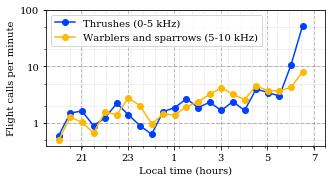

In [10]:
first_hour = 20

# Loop over units.
unit_id = 1

unit_str = units[unit_id]
annotation_path = os.path.join(annotations_dir,
    unit_str + ".txt")
annotation = pd.read_csv(annotation_path, '\t')
begin_times = np.array(annotation["Begin Time (s)"])
end_times = np.array(annotation["End Time (s)"])
relevant = 0.5 * (begin_times + end_times)
relevant = np.sort(relevant)
high_freqs = np.array(annotation["High Freq (Hz)"])
low_freqs = np.array(annotation["Low Freq (Hz)"])
mid_freqs = 0.5 * (high_freqs + low_freqs)
n_relevant = len(relevant)

thrush_low = 0.0
thrush_high = 5000.0
thrush_relevant = relevant[(thrush_low < mid_freqs) & (mid_freqs < thrush_high)]
thrush_x, thrush_y = np.histogram(thrush_relevant, bins=bins)
thrush_x = np.maximum(thrush_x, 15.0)


tseep_low = 5000.0
tseep_high = 10000.0
tseep_relevant = relevant[(tseep_low < mid_freqs) & (mid_freqs < tseep_high)]
tseep_x, tseep_y = np.histogram(tseep_relevant, bins=bins)
tseep_x = np.maximum(tseep_x, 15.0)

fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(5, 2.5))

ax2.plot(
    thrush_y[1:] / 3600 + local_offset,
    np.log10(thrush_x / bin_hop),
    "-o",
    color = "#0040FF")

ax2.plot(
    tseep_y[1:] / 3600 + local_offset,
    np.log10(tseep_x / bin_hop),
    "-o",
    color = "#FFB800")

ax2.set_xticks(1.0 + np.array(range(first_hour, first_hour+n_hours+1)[::2]))
ax2.set_xticklabels([str(np.mod(n, 24))
    for n in range(1+first_hour, first_hour+n_hours+1)][::2], family="serif")
ax2.set_xticks(
    0.5 + np.linspace(first_hour, first_hour+n_hours, n_hours * 2),
    minor=True)
ax2.set_xlabel("Local time (hours)", family="serif")

yticks = [ 0.5, 1, 2, 5, 10, 20, 50, 100]
ax2.set_yticks(np.log10(yticks), minor=True)
ax2.set_yticks(np.log10([1, 10, 100]))
ax2.set_yticklabels(map(str, [1, 10, 100]), family="serif");

ax2.set_ylabel("Flight calls per minute", family="serif")

ax2.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax2.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax2.set_axisbelow(True)

ax2.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
    loc=2, prop={'family':'serif'})

plt.savefig("spl_flight-call-density.png", dpi=500, bbox_inches="tight")
plt.savefig("spl_flight-call-density.svg", dpi=500, bbox_inches="tight")


In [103]:
bin_hop

30

In [11]:
import sys
sys.path.append('../src')
import localmodule
import h5py
import os
import librosa
import numpy as np
from matplotlib import pyplot as plt

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
test_unit_str = "unit03"
bin_hop = 30 # in minutes
n_hours = 11
n_bins = int(np.round(n_hours * (60/bin_hop)))
thrush_low = 2000.0
thrush_high = 2500.0
tseep_low = 4000.0
tseep_high = 5000.0


full_logmelspec_name = "_".join([dataset_name, "full-logmelspec"])
full_logmelspec_dir = os.path.join(data_dir, full_logmelspec_name)
logmelspec_path = os.path.join(full_logmelspec_dir, test_unit_str + ".hdf5")

logmelspec_file = h5py.File(logmelspec_path)

lms_fmin = logmelspec_file["logmelspec_settings"]["fmax"].value
lms_fmax = logmelspec_file["logmelspec_settings"]["fmin"].value
lms_sr = logmelspec_file["logmelspec_settings"]["sr"].value
lms_hop_length = logmelspec_file["logmelspec_settings"]["hop_length"].value
lms_hop_duration = lms_hop_length / lms_sr
n_hops_per_bin = int(bin_hop * 60 / lms_hop_duration)

mel_f = librosa.core.mel_frequencies(
    logmelspec_file["logmelspec_settings"]["n_mels"].value + 2,
    fmin=logmelspec_file["logmelspec_settings"]["fmin"].value,
    fmax=logmelspec_file["logmelspec_settings"]["fmax"].value,
    htk=False)

thrush_mel_start = np.argmin(np.abs(thrush_low - mel_f))
thrush_mel_stop = np.argmin(np.abs(thrush_high - mel_f))

tseep_mel_start = np.argmin(np.abs(tseep_low - mel_f))
tseep_mel_stop = np.argmin(np.abs(tseep_high - mel_f))

thrush_percentiles = []
tseep_percentiles = []

for bin_id in range(n_bins):
    print(bin_id)
    
    bin_start = bin_id * n_hops_per_bin
    bin_stop = bin_start + n_hops_per_bin
    
    thrush_fragment = logmelspec_file["logmelspec"][
        thrush_mel_start:thrush_mel_stop, bin_start:bin_stop]
    thrush_percentiles.append(np.percentile(thrush_fragment, [25, 50, 75]))
    
    
    tseep_fragment = logmelspec_file["logmelspec"][
        tseep_mel_start:tseep_mel_stop, bin_start:bin_stop]
    tseep_percentiles.append(np.percentile(tseep_fragment, [25, 50, 75]))
    

logmelspec_file.close()

thrush_percentiles = np.stack(thrush_percentiles)
tseep_percentiles = np.stack(tseep_percentiles)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


R = 0.89, p = 5e-16 ; n = 44


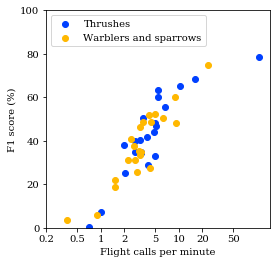

In [6]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))

ax.scatter(
    np.log10((thrush_tp_x + thrush_fn_x) / bin_hop),
    100 * thrush_F_med[:],
    c = "#0040FF")


ax.scatter(
    np.log10((tseep_tp_x + tseep_fn_x) / bin_hop),
    100 * tseep_F_med[:],
    c = "#FFB800")



ax.legend(
    ["Thrushes", "Warblers and sparrows"],
    loc=2,
    prop={'family':'serif','weight':'roman'})

xticks = [0.2, 0.5, 1, 2, 5, 10, 20, 50]
ax.set_xticks(np.log10(xticks))
ax.set_xticklabels([str(xtick) for xtick in xticks], family="serif")
ax.set_xlabel("Flight calls per minute", family="serif")

ax.set_ylim(0, 100);
ax.set_ylabel("F1 score (%)", family="serif")
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(
    [str(F) for F in np.linspace(0, 100, 6).astype('int')],
    family="serif")


mixed_log10_x = np.concatenate([np.log10(thrush_tp_x + thrush_fn_x), np.log10(tseep_tp_x + tseep_fn_x)])
mixed_y = np.concatenate([100 * thrush_F_med[:], 100 * tseep_F_med[:]])
mixed_R, mixed_p = scipy.stats.pearsonr(mixed_log10_x, mixed_y)
print("R = {:3.2f}, p = {:1.0e} ; n = {}".format(mixed_R, mixed_p, len(mixed_y)))

Thrushes. R = -0.59 ; p = 4e-03 ; n = 22
Warblers and sparrows. R = -0.58 ; p = 4e-03 ; n = 22


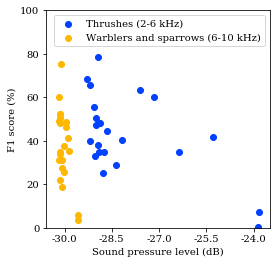

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
thrush_med_noise = thrush_percentiles[:, 1]
thrush_med_noise = thrush_med_noise - np.mean(thrush_med_noise)
thrush_med_noise = thrush_med_noise / np.std(thrush_med_noise)
tseep_med_noise = tseep_percentiles[:, 1]

ax.scatter(
    thrush_med_noise,
    100 * thrush_F_med[:],
    c = "#0040FF")

ax.scatter(
    tseep_med_noise,
    100 * tseep_F_med[:],
    c = "#FFB800")

ax.legend(
    ["Thrushes (2-6 kHz)", "Warblers and sparrows (6-10 kHz)"],
    loc=1,
    prop={'family':'serif'})

xticks = [-30.0, -28.5, -27.0, -25.5, -24.0]
ax.set_xticks(xticks)
ax.set_xticklabels([str(xtick) for xtick in xticks], family="serif")
ax.set_xlabel("Sound pressure level (dB)", family="serif")

ax.set_ylim(0, 100);
ax.set_ylabel("F1 score (%)", family="serif")
ax.set_yticks(np.linspace(0, 100, 6))
ax.set_yticklabels(
    [str(F) for F in np.linspace(0, 100, 6).astype('int')],
    family="serif")


thrush_noise_R, thrush_noise_p = scipy.stats.pearsonr(thrush_med_noise, 100*thrush_F_med[:])
print("Thrushes. R = {:3.2f} ; p = {:1.0e} ; n = {}".format(thrush_noise_R, thrush_noise_p, len(thrush_med_noise)))

tseep_noise_R, tseep_noise_p = scipy.stats.pearsonr(tseep_med_noise, 100*tseep_F_med[:])
print("Warblers and sparrows. R = {:3.2f} ; p = {:1.0e} ; n = {}".format(tseep_noise_R, tseep_noise_p, len(tseep_med_noise)))

In [20]:
tseep_tp_y

array([ 19.51722222,  20.04103175,  20.56484127,  21.08865079,
        21.61246032,  22.13626984,  22.66007937,  23.18388889,
        23.70769841,  24.23150794,  24.75531746,  25.27912698,
        25.80293651,  26.32674603,  26.85055556,  27.37436508,
        27.8981746 ,  28.42198413,  28.94579365,  29.46960317,
        29.9934127 ,  30.51722222])

In [32]:
first_hour + np.linspace(0, n_hours, tseep_percentiles.shape[0])

array([ 20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,
        24.5,  25. ,  25.5,  26. ,  26.5,  27. ,  27.5,  28. ,  28.5,
        29. ,  29.5,  30. ,  30.5])

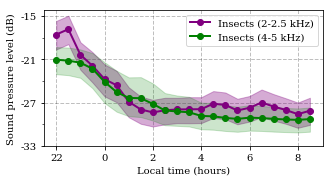

In [18]:
from matplotlib import pyplot as plt
import numpy as np
import datetime
%matplotlib inline

utc_timestamp = 1443065462
utc_datetime = datetime.datetime.fromtimestamp(utc_timestamp)
utc_offset =\
    utc_datetime.hour +\
    utc_datetime.minute / 60 +\
    utc_datetime.second / 3600
local_offset = utc_offset - 4
first_hour = 20


fig, ax3 = plt.subplots(1, 1, sharex=True, figsize=(5, 2.5))

n_hours = 10.5
tseep_tp_y = first_hour + np.linspace(0, n_hours, tseep_percentiles.shape[0])
thrush_tp_y = first_hour + np.linspace(0, n_hours, thrush_percentiles.shape[0])

ax3.fill_between(
    thrush_tp_y,
    thrush_percentiles[:, 0],
    thrush_percentiles[:, 2],
    color = "#80007F",
    alpha = 0.33);

ax3.plot(
    thrush_tp_y,
    thrush_percentiles[:, 1],
    "-o",
    color = "#80007F",
    linewidth = 2.0)


ax3.fill_between(
    tseep_tp_y,
    tseep_percentiles[:, 0],
    tseep_percentiles[:, 2],
    color = "#008000",
    alpha = 0.2);

ax3.plot(
    tseep_tp_y,
    tseep_percentiles[:, 1],
    "-o",
    color = "#008000",
    linewidth = 2.0)




ax3.set_xticks(range(first_hour, first_hour+1)[::2],  minor=True)
ax3.set_xticklabels([str(np.mod(n, 24))
    for n in range(first_hour, first_hour+13)][::2], family="serif")
#ax3.set_xticks(
#    np.linspace(first_hour, first_hour+ 11 - 0.5, n_hours * 2),
#    minor=True)
ax3.set_xlabel("Local time (hours)", family="serif")

ydBs = [-33, -30, -27, -24, -21, -18, -15]
ax3.set_yticks(ydBs[::2])
ax3.set_yticks(ydBs, minor=True)
ax3.set_yticklabels([str(ydB) for ydB in ydBs[::2]], family="serif");
ax3.set_ylabel("Sound pressure level (dB)", family="serif")

ax3.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
#ax3.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax3.set_axisbelow(True)

ax3.legend(["Insects (2-2.5 kHz)", "Insects (4-5 kHz)"],
    loc=1, prop={'family':'serif'})

plt.savefig("spl_fig_db.png", dpi=500, bbox_inches="tight")

plt.savefig("spl_fig_db.svg", dpi=500, bbox_inches="tight")

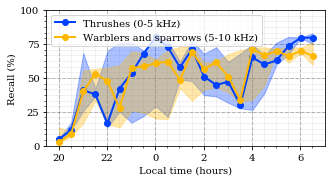

In [3]:

utc_timestamp = 1443065462
utc_datetime = datetime.datetime.fromtimestamp(utc_timestamp)
utc_offset =\
    utc_datetime.hour +\
    utc_datetime.minute / 60 +\
    utc_datetime.second / 3600
local_offset = utc_offset - 4
first_hour = 20
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(5, 2.5))


thrush_R_Q1 = np.sort(np.stack(thrush_Rs), axis=0)[1]
thrush_R_med = np.sort(np.stack(thrush_Rs), axis=0)[2]
thrush_R_Q3 = np.sort(np.stack(thrush_Rs), axis=0)[3]

thrush_F_Q1 = np.sort(np.stack(thrush_Fs), axis=0)[1]
thrush_F_med = np.sort(np.stack(thrush_Fs), axis=0)[2]
thrush_F_Q3 = np.sort(np.stack(thrush_Fs), axis=0)[3]

ax1.fill_between(
    thrush_tp_y[1:] / 3600 + local_offset,
    100 * thrush_F_Q1[:],
    100 * thrush_F_Q3[:],
    color = "#0040FF",
    alpha = 0.33)

ax1.plot(
    thrush_tp_y[1:] / 3600 + local_offset,
    100 * thrush_F_med[:],
    "-o",
    color = "#0040FF",
    linewidth = 2.0)


tseep_R_Q1 = np.sort(np.stack(tseep_Rs), axis=0)[1]
tseep_R_med = np.sort(np.stack(tseep_Rs), axis=0)[2]
tseep_R_Q3 = np.sort(np.stack(tseep_Rs), axis=0)[3]

tseep_F_Q1 = np.sort(np.stack(tseep_Fs), axis=0)[1]
tseep_F_med = np.sort(np.stack(tseep_Fs), axis=0)[2]
tseep_F_Q3 = np.sort(np.stack(tseep_Fs), axis=0)[3]


ax1.fill_between(
    tseep_tp_y[1:] / 3600 + local_offset,
    100 * tseep_F_Q1[:],
    100 * tseep_F_Q3[:],
    color = "#FFB800",
    alpha = 0.33)

ax1.plot(
    tseep_tp_y[1:] / 3600 + local_offset,
    100 * tseep_F_med[:],
    "-o",
    color = "#FFB800",
    linewidth = 2.0)

ax1.legend(["Thrushes (0-5 kHz)", "Warblers and sparrows (5-10 kHz)"],
    loc=2, prop={'family':'serif'})

ax1.set_xticks(range(first_hour, first_hour+n_hours+1)[::2])
ax1.set_xticklabels([str(np.mod(n, 24))
    for n in range(first_hour, first_hour+n_hours+1)][::2], family="serif")
ax1.set_xticks(
    np.linspace(first_hour, first_hour+n_hours - 0.5, n_hours * 2),
    minor=True)
ax1.set_xlabel("Local time (hours)", family="serif")

ax1.set_ylim(0, 100)
ax1.set_ylabel("Recall (%)", family="serif")
ax1.set_yticks(np.linspace(0, 100, 5))
ax1.set_yticklabels(np.linspace(0, 100, 5).astype('int'), family="serif")
ax1.set_yticks(np.linspace(0, 100, 25), minor=True)

ax1.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax1.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax1.set_axisbelow(True)

plt.savefig("icassp_fig_recall-time_a.png", dpi=500, bbox_inches="tight")
plt.savefig("icassp_fig_recall-time_a.svg", bbox_inches="tight")